In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

### Level 1 - Solve the acoustic isotropic wave equation in 1D with absorbing boundary conditions and a point source

[Acoustic Isotropic Wave Equation](http://sepwww.stanford.edu/sep/prof/bei/fdm/paper_html/node40.html#SECTION00180000000000000000):
$$
\frac{1}{c^2}\frac{\partial^2 u}{\partial t^2} = \nabla^2 u + f
$$

Where $u$ is pressure, $t$ is time, $\nabla^2$ is the Laplacian and $f$ is a forcing function (acoustic source).
In one-dimension, this looks like:

$$
\frac{1}{c^2}\frac{\partial^2 u}{\partial t^2} = \frac{\partial^2 u}{\partial x^2} + f
$$

And can be solved using the finite-difference method as follows:

$$
\frac{1}{c^2} \frac{u_i^{t+1} - 2u_i^{t} + u_i^{t-1}}{\Delta t^2} = \frac{1}{\Delta x^2} \left(a_0 u_{i}^{t} + \sum_{n=1}^{M/2} \left( u_{i-n}^{t} - u_{i+n}^{t} \right) \right) + f
$$

This uses a second-order trapezoidal integration in time, which for hyperbolic PDEs is sufficient, $a$ represents a vector of Taylor Series coefficients and M is the spatial order. This is solved for $u_i^{t+1}$ in the interior ($M/2 \lt i \le NX-M/2$, $M/2 \lt j \le NY-M/2$, $M/2 \lt k \le NZ-M/2$).

We apply a [one-way wave equation at the boundaries](https://www.mdpi.com/2624-599X/2/1/12) ($i \le M/2, i \gt NX-M/2, j \le M/2, j \gt NY-M/2, k \le M/2, i \gt NZ-M/2$) as our absorbing boundary condition by factorizing the acoustic wave equation into forward ($c_+$) and backward ($c_-$) directions:

$$
\left( \frac{\partial^2}{\partial t^2} - c^2\frac{\partial^2}{\partial x^2} \right) u = 
\left( \frac{\partial}{\partial t} - c\frac{\partial}{\partial x} \right)\left( \frac{\partial}{\partial t} + c\frac{\partial}{\partial x} \right) u = 0
$$

Which is tantamount to an upwind and downwind discretisation at the boundaries to usher the wavefield out of the domain while preventing transfer of information back into the domain.

In [2]:
NX = int(512)
NT = int(2000)

ORDER  = 8
VEL    = 1000.
C_CRIT = 0.3

DX = 10.
DT = C_CRIT * DX / VEL

L = NX * DX
T = NT * DT

In [3]:
def init_src_wavelet(dt):
    df = 0.1
    fmin = 2.
    fmax = 12.
    ntsource = int(150)
    nf = int((fmax-fmin)/df)+1
    if (nf%2==0):
        nf += 1
    ifctr = int(nf/2)+1
    source = np.zeros(2*ntsource+1)
    for ifreq in range(1,nf+1):
        f = fmin + (ifreq-1)*df
        watef = 0.5 + 0.5*np.cos(np.pi*(ifreq-ifctr)/float(ifctr))
        watef = watef**(1/3)
        for it in range(-ntsource,ntsource+1):
            source[it+ntsource] += np.cos(2*np.pi*f*it*dt)*watef;
        
    for it in range(-ntsource,ntsource+1):
        source[it+ntsource] *= 0.5 + 0.5*np.cos(np.pi*it/float(ntsource))
    return source

In [4]:
def first_order_taylor_coefficients(spatial_order):
    if spatial_order == 2:
        return np.array([1.])
    elif spatial_order == 4:
        return np.array([27., -1.])/24.
    elif spatial_order == 6:
        return np.array([2250., -125., 9.])/1920.
    elif spatial_order == 8:
        return np.array([128625., -8575., 1029., -75.])/107520.
    elif spatial_order == 10:
        return np.array([12502350., -926100., 142884., -18225., 1225.])/10321920.
    elif spatial_order == 12:
        return np.array([1109375190., -88045650., 15848217., -2695275., 326095., -19845.])/908328960.
    else:
        raise ValueError("Order not yet implemented")
        
def second_order_taylor_coefficients(spatial_order):
    # zeroth fd-coefficients multiplied by ndim for each dimension
    if spatial_order==2:
        return np.array([-2.,1.])
    elif spatial_order==4:
        return np.array([-5./2.,4./3.,-1./12.])
    elif spatial_order==6:
        return np.array([-49./18.,3./2.,-3./20.,1./90.])
    elif spatial_order==8:
        return np.array([-205./72.,8./5.,-1./5.,8./315.,-1./560.])
    else:
        raise ValueError("Order not yet implemented")

In [5]:
@njit
def abc1d(u1,u2,v, rad, istart, inc):
    # v expects to be v*dt/dx
    v_coef = (1-v)/(1+v)
    
    ind_prev = istart
    ind_curr = istart + inc
    
    u2_prev = u2[ind_prev]
    u1_prev = u1[ind_prev]
    
    for i in range(rad):
        u1_curr = u1[ind_curr]
        u2_curr = v_coef*(u1_curr - u2_prev) + u1_prev
        u2[ind_curr] = u2_curr
        
        u2_prev = u2_curr
        u1_prev = u1_curr
        ind_prev = ind_curr
        ind_curr += inc
    return

In [6]:
@njit
def iso_timestep1d(u1,u2,vel2,nx,spatial_order,coeffs):
    # calculate the laplacian in the spatial domain
    # ! Does not require allocation of laplacian array
    # ! using this re-jigging
    stencil_rad = int(spatial_order/2)
    for i in range(stencil_rad,nx-stencil_rad):
        lap = coeffs[0]*u1[i]
        for j in range(1,stencil_rad+1):
            lap += coeffs[j]*(u1[i+j] + u1[i-j])
        u2[i] = 2*u1[i] - u2[i]  + vel2 * lap
    return

In [7]:
def extrapolate1d(u1,u2,vel,dx,dt,nx,nt,source,order):
    bc_stencil = int(order/2)    # BC length only needs to be as wide as the stencil radius' knowledge of the gradient
    coeffs = second_order_taylor_coefficients(order)
    vel *= dt/dx; vel *= vel
    for i in range(nt):
        u1,u2=u2,u1; assert u1 is not u2
        iso_timestep1d(u1,u2,vel,nx,order,coeffs) # calculate laplacian in spatial domain and timestep
        abc1d(u1,u2,np.sqrt(vel), bc_stencil, bc_stencil,     -1)  # left
        abc1d(u1,u2,np.sqrt(vel), bc_stencil, nx-bc_stencil-1,+1)  # right
        if i<len(source):
            u2[nx//5] += source[i] # add forcing function
        if i%100==0: 
            plt.plot(u2)
            plt.ylim([-1500.,+1500])
            plt.show()
    return

Domain length = 5120.0 m, 
         Propagating for T = 6.0 s, 
         in velocity model of V = 1000.0 m/s,
         using Finite-Difference Order = 8,
         Grid params: NX = 512, NT = 2000,
         DX = 10.0 m, DT = 3.000 ms, COURANT = 0.3


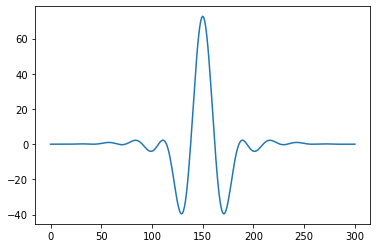

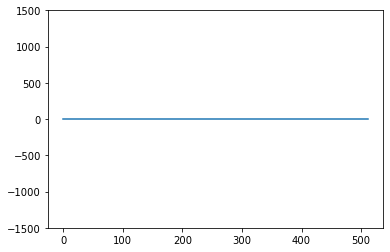

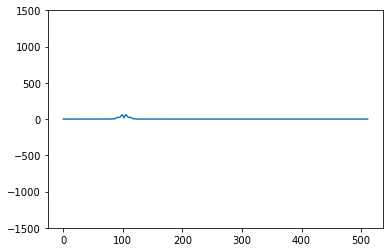

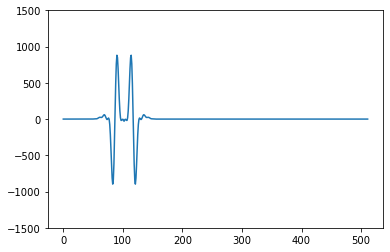

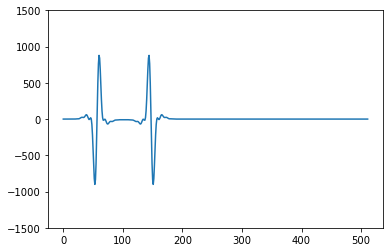

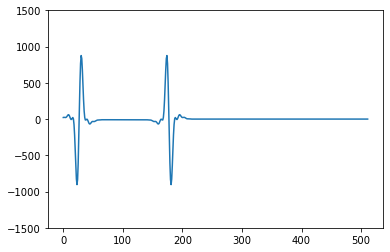

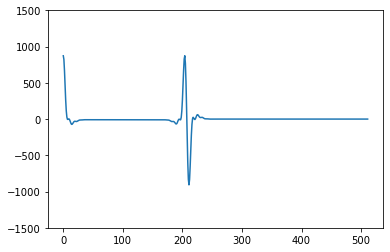

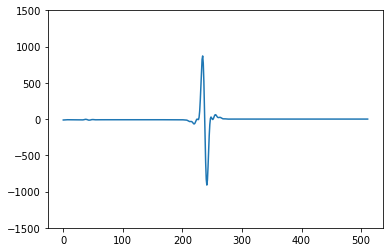

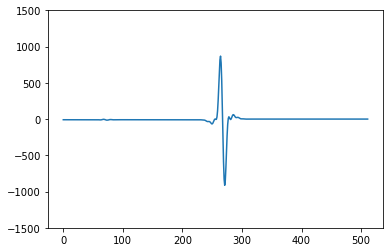

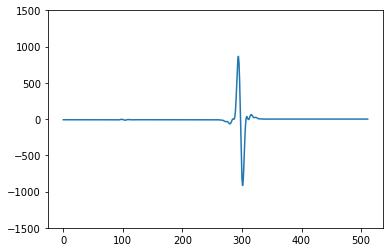

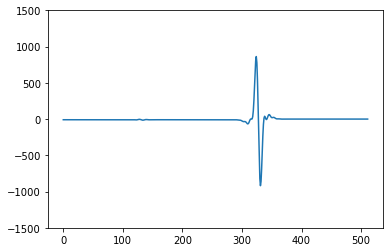

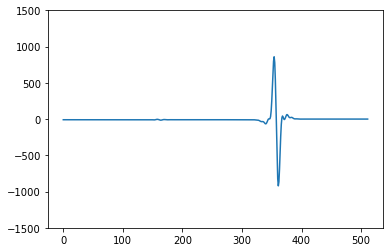

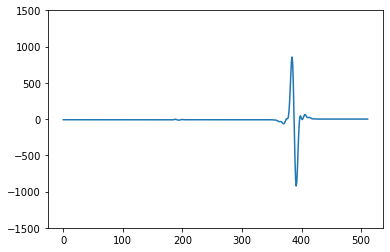

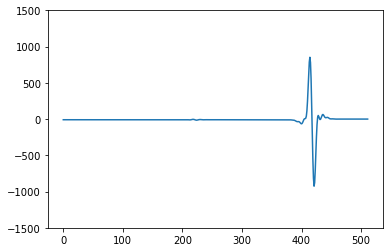

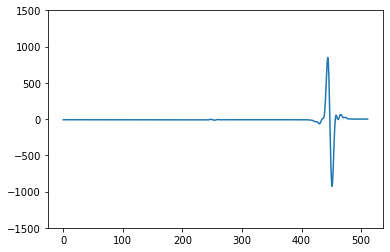

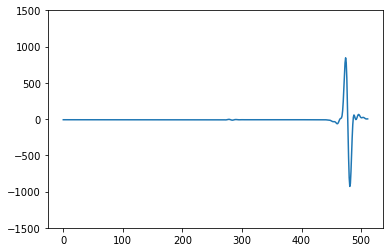

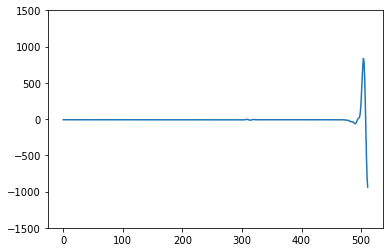

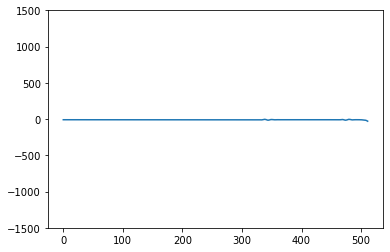

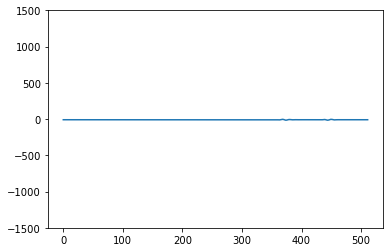

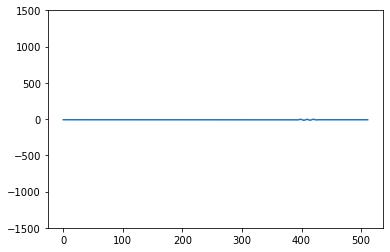

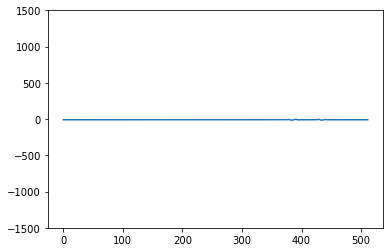

In [8]:
SOURCE = init_src_wavelet(DT)
print("""Domain length = %.1f m, 
         Propagating for T = %.1f s, 
         in velocity model of V = %.1f m/s,
         using Finite-Difference Order = %d,
         Grid params: NX = %d, NT = %d,
         DX = %.1f m, DT = %.3f ms, COURANT = %.1f""" % (L,T,VEL,ORDER,NX,NT,DX,DT*1e3,C_CRIT))

plt.plot(SOURCE); plt.show()

print("="*100)
u1 = np.zeros(NX)
u2 = np.zeros(NX)
extrapolate1d(u1,u2,VEL,DX,DT,NX,NT,SOURCE,ORDER)

### Level 2 - Solve the acoustic isotropic wave equation in 1D with absorbing boundary conditions and a point source

In three dimensions, the acoustic isotropic wave equation looks like:

$$
\frac{1}{c^2} \frac{u_{i,j,k}^{t+1} - 2u_{i,j,k}^{t} + u_{i,j,k}^{t-1}}{\Delta t^2} = \frac{1}{\Delta x^2} \left(\nabla_x^2 u + \nabla_y^2 u + \nabla_z^2 u \right) + f
$$

Where:

$$
\begin{aligned}
\nabla_x^2 u &= \left(a_0 u_{i,j,k}^{t} + \sum_{n=1}^{M/2} a_n \left( u_{i-n,j,k}^{t} - u_{i+n,j,k}^{t} \right) \right) \\
\nabla_y^2 u &= \left(a_0 u_{i,j,k}^{t} + \sum_{n=1}^{M/2} a_n \left( u_{i,j-n,k}^{t} - u_{i,j+n,k}^{t} \right) \right) \\
\nabla_z^2 u &= \left(a_0 u_{i,j,k}^{t} + \sum_{n=1}^{M/2} a_n \left( u_{i,j,k-n}^{t} - u_{i,j,k+n}^{t} \right) \right) \\
\end{aligned}
$$

The one-way wave equation remains one-dimensional, and is applied in one-dimension at each boundary point, orthoganal to the boundary plane at which the point sits.

In [9]:
@njit
def abc3d(u1,u2,v, nx,ny,nz, rad):
    # do 12(xy)-planes
    for j in range(ny):
        for i in range(nx):
            abc1d(u1[i,j,:], u2[i,j,:], v, rad, rad,      -1)
            abc1d(u1[i,j,:], u2[i,j,:], v, rad, nz-rad-1, +1)
    # do 23(yz)-planes
    for k in range(nz):
        for j in range(ny):
            abc1d(u1[:,j,k], u2[:,j,k], v, rad, rad,      -1)
            abc1d(u1[:,j,k], u2[:,j,k], v, rad, nx-rad-1, +1)
    # do 13(xz)-planes
    for k in range(nz):
        for i in range(nx):
            abc1d(u1[i,:,k], u2[i,:,k], v, rad, rad,      -1)
            abc1d(u1[i,:,k], u2[i,:,k], v, rad, ny-rad-1, +1)
    return

In [10]:
@njit
def iso_timestep3d(u1,u2,vel2,nx,ny,nz,spatial_order,coeffs):
    # calculate the laplacian in the spatial domain
    # and integrate forward in time
    stencil_rad = spatial_order//2
    for k in range(stencil_rad,nz-stencil_rad):
        for j in range(stencil_rad,ny-stencil_rad):
            for i in range(stencil_rad,nx-stencil_rad):
                lap = coeffs[0]*u1[i,j,k]*3. # three-dimensions
                for c in range(1,stencil_rad+1):
                    lap += coeffs[c]*(u1[i+c,j,k] + u1[i-c,j,k] 
                                    + u1[i,j+c,k] + u1[i,j-c,k] 
                                    + u1[i,j,k+c] + u1[i,j,k-c])
                u2[i,j,k] = 2.*u1[i,j,k] - u2[i,j,k] + vel2 * lap
    return

In [15]:
def extrapolate3d(u1,u2,vel,dx,dt,nx,ny,nz,nt,source,order):
    
    bc_stencil = order // 2    # BC length only needs to be as wide as the stencil radius' knowledge of the gradient
    coeffs = second_order_taylor_coefficients(order)
    vel *= dt/dx; vel *= vel
    stencil_rad = order//2
    for it in range(nt):
        
        u1,u2 = u2,u1; assert u1 is not u2
        iso_timestep3d(u1,u2,vel,nx,ny,nz,order,coeffs) # calculate laplacian in spatial domain and timestep
        abc3d(u1,u2,np.sqrt(vel), nx,ny,nz, bc_stencil)
        
        if it<len(source):
            u1[nx//2,ny//2,nz//2] += source[it] # add forcing function

        if it%50==0:
            print(f'Timestep = {it}')
            plt.imshow(u2[:,:,nz//2], vmin=-1., vmax=+1.)
            plt.colorbar()
            plt.show()
    return


Domain length = 1280.0 m, 
Propagating for T = 6.1 s, 
in velocity model of V = 1000.0 m/s,
using Finite-Difference Order = 8,
Grid params: NX = 128, NT = 2048,
DX = 10.0 m, DT = 3.000 ms, COURANT = 0.3



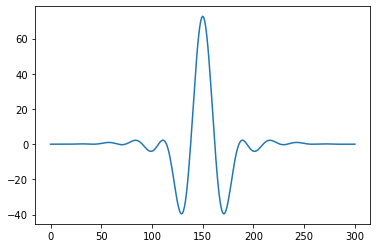

Timestep = 0


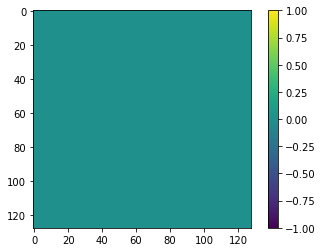

Timestep = 50


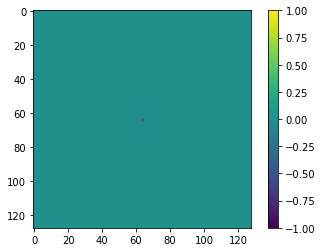

Timestep = 100


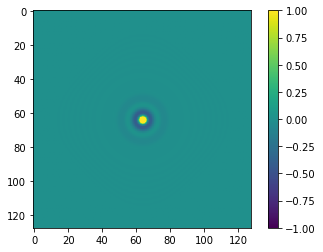

Timestep = 150


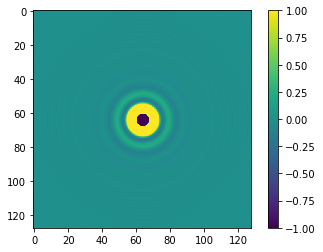

Timestep = 200


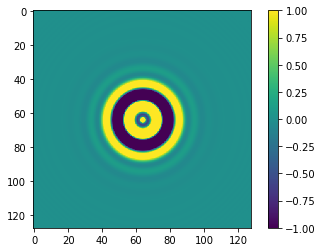

Timestep = 250


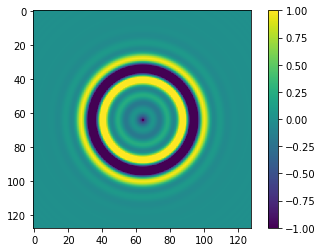

Timestep = 300


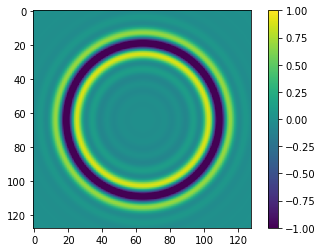

Timestep = 350


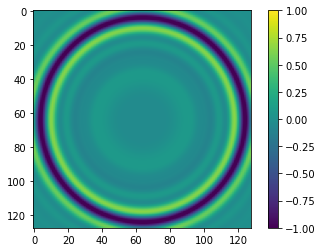

Timestep = 400


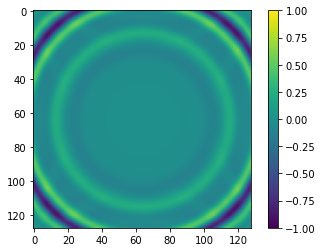

Timestep = 450


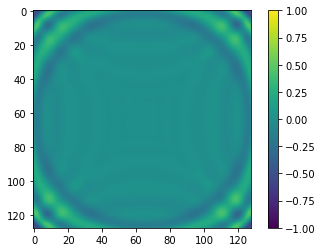

Timestep = 500


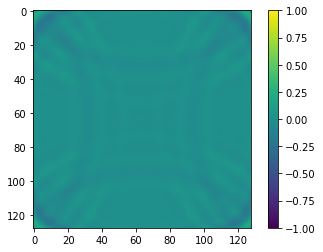

Timestep = 550


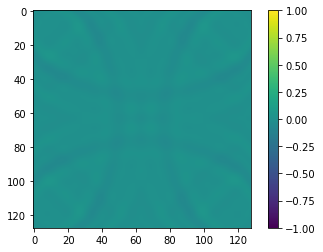

Timestep = 600


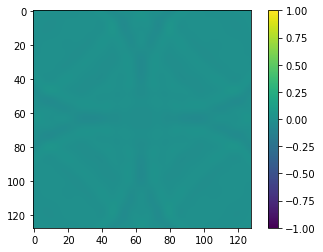

Timestep = 650


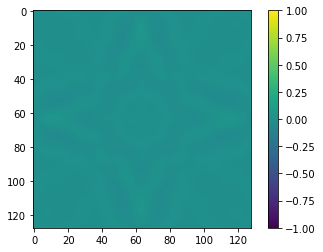

Timestep = 700


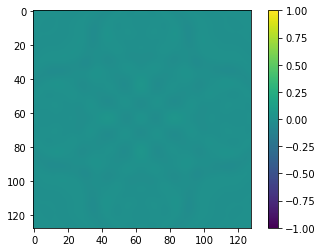

Timestep = 750


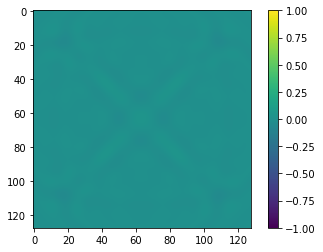

Timestep = 800


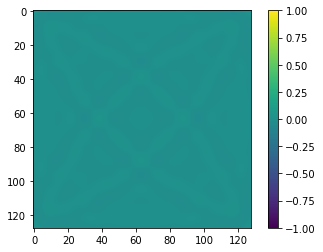

Timestep = 850


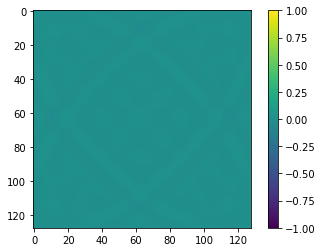

Timestep = 900


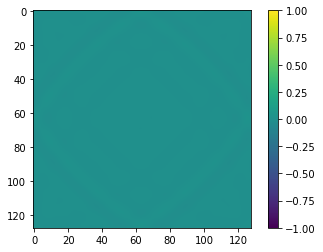

Timestep = 950


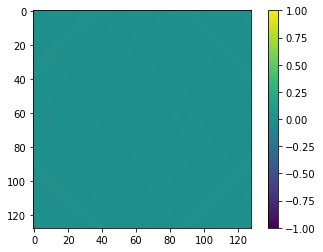

Timestep = 1000


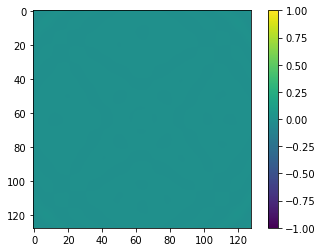

Timestep = 1050


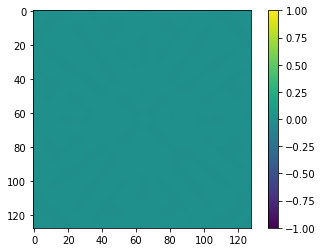

Timestep = 1100


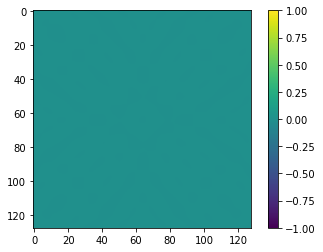

Timestep = 1150


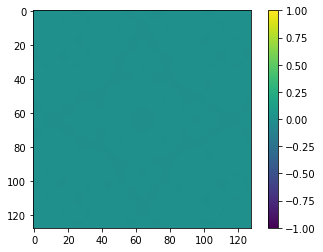

Timestep = 1200


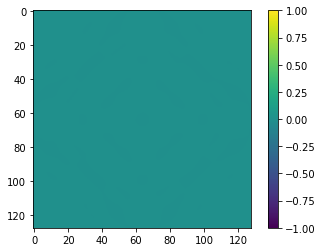

Timestep = 1250


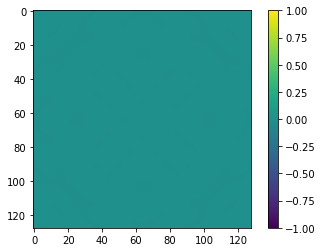

Timestep = 1300


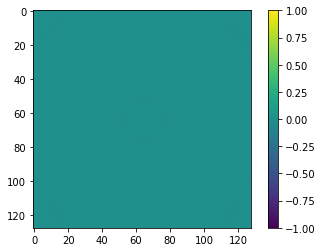

Timestep = 1350


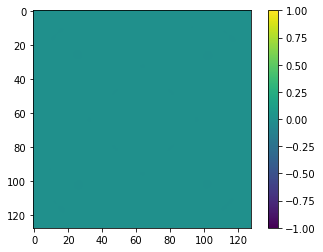

Timestep = 1400


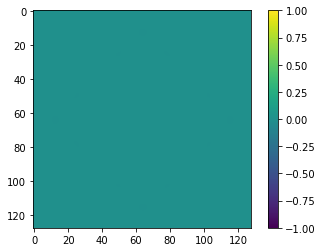

Timestep = 1450


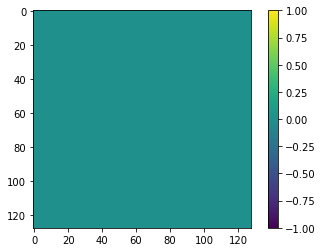

Timestep = 1500


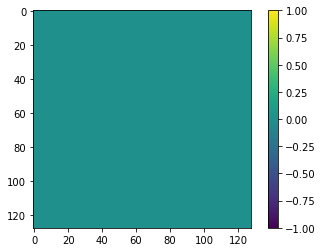

Timestep = 1550


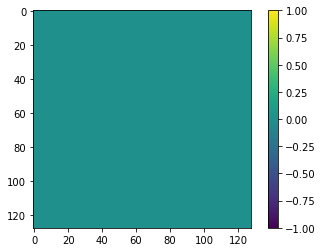

Timestep = 1600


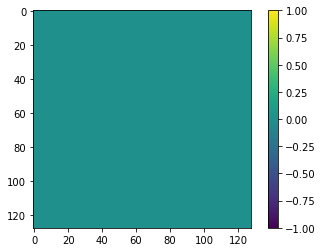

Timestep = 1650


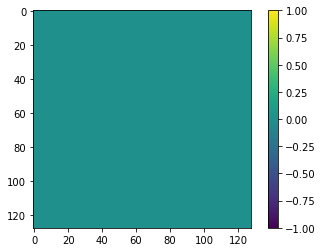

Timestep = 1700


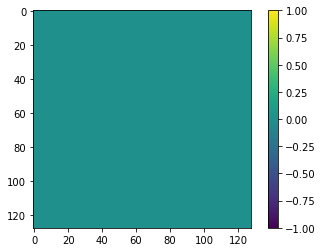

Timestep = 1750


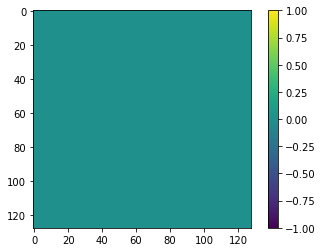

Timestep = 1800


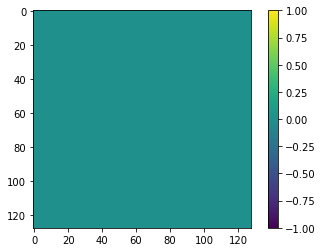

Timestep = 1850


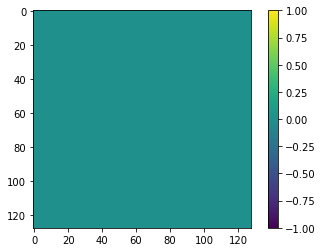

Timestep = 1900


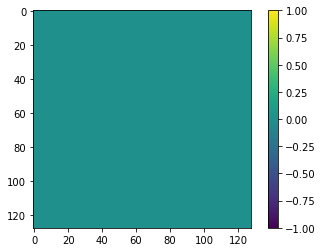

Timestep = 1950


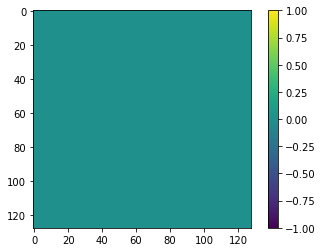

Timestep = 2000


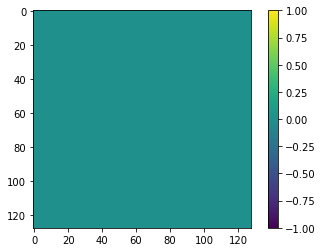

In [16]:
NX = int(128)
NY = int(128)
NZ = int(64)
NT = int(2048)

ORDER  = 8
VEL    = 1000.
C_CRIT = 0.3

DX = 10.
DY = 10.
DT = C_CRIT * DX / VEL

L = NX * DX
T = NT * DT

print("""
Domain length = %.1f m, 
Propagating for T = %.1f s, 
in velocity model of V = %.1f m/s,
using Finite-Difference Order = %d,
Grid params: NX = %d, NT = %d,
DX = %.1f m, DT = %.3f ms, COURANT = %.1f
""" % (L,T,VEL,ORDER,NX,NT,DX,DT*1e3,C_CRIT))

SOURCE = init_src_wavelet(DT)
plt.plot(SOURCE); plt.show()

u1 = np.zeros((NX,NY,NZ))
u2 = np.zeros((NX,NY,NZ))
extrapolate3d(u1,u2,VEL,DX,DT,NX,NY,NZ,NT,SOURCE,ORDER)